# <a id="table-of-contents"></a>Table of Contents

1. [Intraday Mean Reversion](#section1)
2. [Moving Average](#section2)
3. [Generalized Estimating Equations](#section3)




In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
import seaborn as sns
import statsmodels.formula.api as smf

from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import precision_recall_curve, confusion_matrix, mean_squared_error, r2_score, ConfusionMatrixDisplay, accuracy_score,  roc_curve, auc, average_precision_score

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.cov_struct import Autoregressive

In [2]:
# Define the path to the Downloads folder and the file
downloads_folder = os.path.expanduser("~/Desktop")
file_name = "aaHistoricalData_1726248252859.csv" 
file_path = os.path.join(downloads_folder, file_name)

# Read the CSV file into a DataFrame
data = pd.read_csv(file_path)

In [3]:
# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Sort the DataFrame by date in ascending order
data = data.sort_values(by='Date', ascending=True)

print(data.head(3))

           Date  Close/Last     Volume    Open    High     Low
2515 2014-09-15     198.981   76350030  199.16  199.32  198.38
2514 2014-09-16     200.480  116039000  198.61  200.84  198.50
2513 2014-09-17     200.750  149647200  200.77  201.68  199.75


In [4]:
# Assuming 'data' is your existing DataFrame
data['Original_Index'] = data.index  # Add the Original_Index column to capture current index
print('''It will record the INDEX to make sure that future data manipulations don't force us to lose the order.''')

It will record the INDEX to make sure that future data manipulations don't force us to lose the order.


In [5]:
# Assuming 'data' is your DataFrame
data['day_change'] = data['Close/Last'] - data['Open']

# Logistic regression preparation: Convert 'day_change' to binary and create a new column 'day_change_binary' (0 for Down, 1 for Up)
data['day_change_binary'] = data['day_change'].apply(lambda x: 1 if x > 0 else 0)

# Create moving averages in a separate DataFrame with the desired naming convention
moving_averages = pd.DataFrame()
binary_variables = pd.DataFrame()

for i in range(1, 51):
    ma_column_value = f'MA_{i}'
    binary_column = f'open_above_MA_{i}'

    # Calculate the moving average and create the binary variable
    moving_averages[ma_column_value] = data['Close/Last'].shift(1).rolling(window=i).mean()
    binary_variables[binary_column] = (data['Open'] > moving_averages[ma_column_value]).astype(int)

# Concatenate the original data, moving_averages, and binary_variables
data = pd.concat([data, moving_averages, binary_variables], axis=1)

# Drop all rows with NaN values
data.dropna(inplace=True)

# Set display option to show all columns
pd.set_option('display.max_columns', None)

data.head(1)

,Date,Close/Last,Volume,Open,High,Low,Original_Index,day_change,day_change_binary,MA_1,MA_2,MA_3,MA_4,MA_5,MA_6,MA_7,MA_8,MA_9,MA_10,MA_11,MA_12,MA_13,MA_14,MA_15,MA_16,MA_17,MA_18,MA_19,MA_20,MA_21,MA_22,MA_23,MA_24,MA_25,MA_26,MA_27,MA_28,MA_29,MA_30,MA_31,MA_32,MA_33,MA_34,MA_35,MA_36,MA_37,MA_38,MA_39,MA_40,MA_41,MA_42,MA_43,MA_44,MA_45,MA_46,MA_47,MA_48,MA_49,MA_50,open_above_MA_1,open_above_MA_2,open_above_MA_3,open_above_MA_4,open_above_MA_5,open_above_MA_6,open_above_MA_7,open_above_MA_8,open_above_MA_9,open_above_MA_10,open_above_MA_11,open_above_MA_12,open_above_MA_13,open_above_MA_14,open_above_MA_15,open_above_MA_16,open_above_MA_17,open_above_MA_18,open_above_MA_19,open_above_MA_20,open_above_MA_21,open_above_MA_22,open_above_MA_23,open_above_MA_24,open_above_MA_25,open_above_MA_26,open_above_MA_27,open_above_MA_28,open_above_MA_29,open_above_MA_30,open_above_MA_31,open_above_MA_32,open_above_MA_33,open_above_MA_34,open_above_MA_35,open_above_MA_36,open_above_MA_37,open_above_MA_38,open_above_MA_39,open_above_MA_40,open_above_MA_41,open_above_MA_42,open_above_MA_43,open_above_MA_44,open_above_MA_45,open_above_MA_46,open_above_MA_47,open_above_MA_48,open_above_MA_49,open_above_MA_50
2465,2014-11-24,207.26,65635340,207.17,207.39,206.91,2465,0.09,1,206.68,206.13,205.826667,205.7575,205.48,205.273333,205.118571,204.97375,204.885,204.7945,204.662273,204.53625,204.367308,204.131786,203.974333,203.829688,203.567941,203.264722,203.009211,202.66675,202.369762,202.031591,201.625435,201.310625,200.8702,200.393269,199.870185,199.390179,198.987069,198.601163,198.341126,198.166091,198.119845,197.976909,197.928711,197.889581,197.794727,197.704076,197.686536,197.682873,197.688168,197.656069,197.700347,197.707384,197.739442,197.803802,197.889253,197.948852,198.000508,198.020118,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


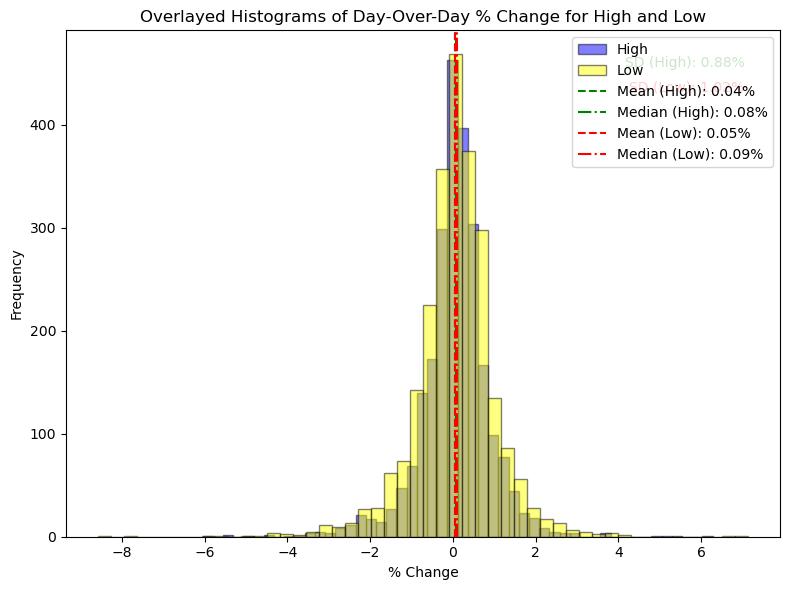

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate day-over-day percentage change for each column (Close/Last, Open, High, Low)
columns_to_calculate = ['Close/Last', 'Open', 'High', 'Low', 'Volume']
for column in columns_to_calculate:
    data[f'{column}_pct_change'] = data[column].pct_change() * 100  # Convert to percentage

# Define columns for percentage change (only include High and Low for the histogram)
pct_change_columns = [f'{column}_pct_change' for column in ['High', 'Low']]

# Set up the figure for the overlapping histograms (for High and Low)
fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)

# Drop NaN values that result from pct_change()
clean_data_high = data['High_pct_change'].dropna()
clean_data_low = data['Low_pct_change'].dropna()

# Calculate standard deviation, mean, and median for High and Low
std_dev_high = clean_data_high.std()
mean_high = clean_data_high.mean()
median_high = clean_data_high.median()

std_dev_low = clean_data_low.std()
mean_low = clean_data_low.mean()
median_low = clean_data_low.median()

# Plot histograms with overlapping colors for High and Low
ax.hist(clean_data_high, bins=50, color='blue', alpha=0.5, label='High', edgecolor='black')
ax.hist(clean_data_low, bins=50, color='yellow', alpha=0.5, label='Low', edgecolor='black')

# Add mean, median lines, and standard deviation text
ax.axvline(mean_high, color='green', linestyle='--', label=f'Mean (High): {mean_high:.2f}%')
ax.axvline(median_high, color='green', linestyle='-.', label=f'Median (High): {median_high:.2f}%')
ax.text(0.95, 0.95, f'SD (High): {std_dev_high:.2f}%', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes, color='green')

ax.axvline(mean_low, color='red', linestyle='--', label=f'Mean (Low): {mean_low:.2f}%')
ax.axvline(median_low, color='red', linestyle='-.', label=f'Median (Low): {median_low:.2f}%')
ax.text(0.95, 0.90, f'SD (Low): {std_dev_low:.2f}%', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes, color='red')

# Title and labels
ax.set_title('Overlayed Histograms of Day-Over-Day % Change for High and Low')
ax.set_xlabel('% Change')
ax.set_ylabel('Frequency')

# Show legend
ax.legend()

# Show the plot
plt.show()


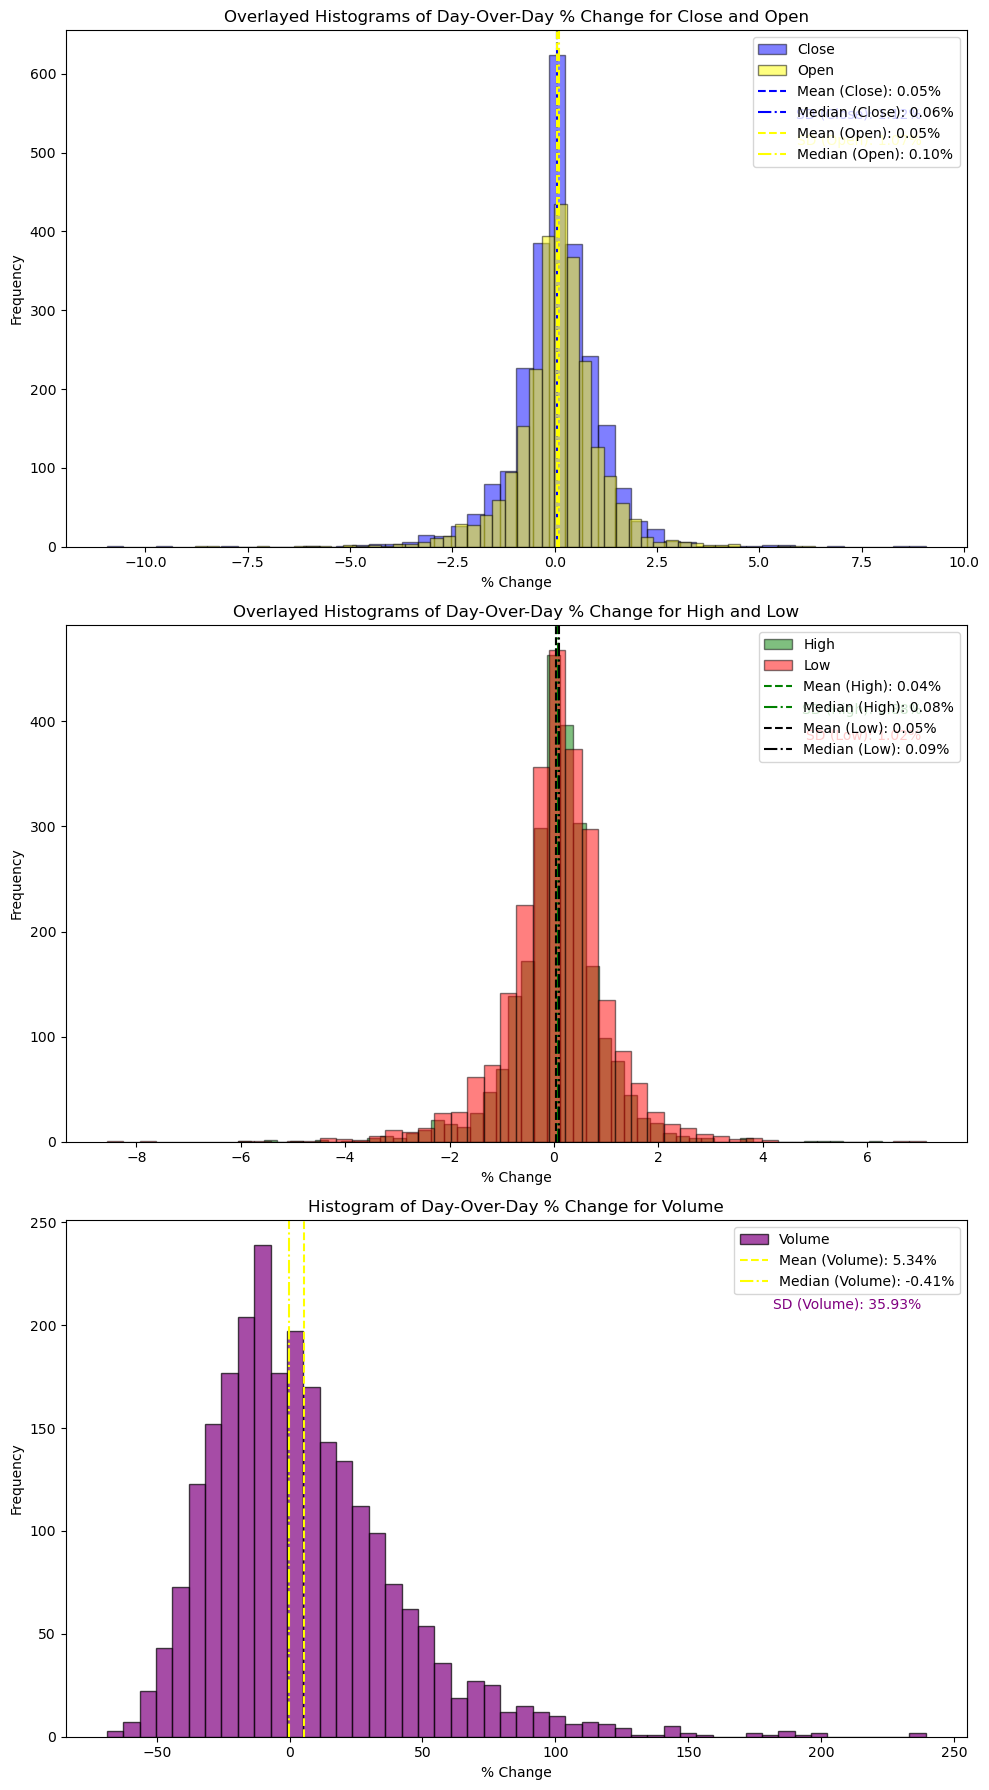

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate day-over-day percentage change for each column (Close/Last, Open, High, Low, Volume)
columns_to_calculate = ['Close/Last', 'Open', 'High', 'Low', 'Volume']
for column in columns_to_calculate:
    data[f'{column}_pct_change'] = data[column].pct_change() * 100  # Convert to percentage

# Define columns for percentage change
pct_change_columns = ['Close/Last_pct_change', 'Open_pct_change', 'High_pct_change', 'Low_pct_change', 'Volume_pct_change']

# Set up the figure for the overlapping histograms
fig, axes = plt.subplots(3, 1, figsize=(10, 18), tight_layout=True)

# Drop NaN values that result from pct_change()
clean_data_close = data['Close/Last_pct_change'].dropna()
clean_data_open = data['Open_pct_change'].dropna()
clean_data_high = data['High_pct_change'].dropna()
clean_data_low = data['Low_pct_change'].dropna()
clean_data_volume = data['Volume_pct_change'].dropna()

# Calculate standard deviation, mean, and median for Close/Last, Open, High, Low, and Volume
std_dev_close = clean_data_close.std()
mean_close = clean_data_close.mean()
median_close = clean_data_close.median()

std_dev_open = clean_data_open.std()
mean_open = clean_data_open.mean()
median_open = clean_data_open.median()

std_dev_high = clean_data_high.std()
mean_high = clean_data_high.mean()
median_high = clean_data_high.median()

std_dev_low = clean_data_low.std()
mean_low = clean_data_low.mean()
median_low = clean_data_low.median()

std_dev_volume = clean_data_volume.std()
mean_volume = clean_data_volume.mean()
median_volume = clean_data_volume.median()

# Plot histograms for Close and Open (overlaid)
axes[0].hist(clean_data_close, bins=50, color='blue', alpha=0.5, label='Close', edgecolor='black')
axes[0].hist(clean_data_open, bins=50, color='yellow', alpha=0.5, label='Open', edgecolor='black')

# Add mean, median lines, and standard deviation text for Close and Open
axes[0].axvline(mean_close, color='blue', linestyle='--', label=f'Mean (Close): {mean_close:.2f}%')
axes[0].axvline(median_close, color='blue', linestyle='-.', label=f'Median (Close): {median_close:.2f}%')
axes[0].text(0.95, 0.85, f'SD (Close): {std_dev_close:.2f}%', horizontalalignment='right', verticalalignment='top', transform=axes[0].transAxes, color='blue')

axes[0].axvline(mean_open, color='yellow', linestyle='--', label=f'Mean (Open): {mean_open:.2f}%')
axes[0].axvline(median_open, color='yellow', linestyle='-.', label=f'Median (Open): {median_open:.2f}%')
axes[0].text(0.95, 0.80, f'SD (Open): {std_dev_open:.2f}%', horizontalalignment='right', verticalalignment='top', transform=axes[0].transAxes, color='yellow')

# Title, labels, and legend for Close and Open plot
axes[0].set_title('Overlayed Histograms of Day-Over-Day % Change for Close and Open')
axes[0].set_xlabel('% Change')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Plot histograms for High and Low (overlaid)
axes[1].hist(clean_data_high, bins=50, color='green', alpha=0.5, label='High', edgecolor='black')
axes[1].hist(clean_data_low, bins=50, color='red', alpha=0.5, label='Low', edgecolor='black')

# Add mean, median lines, and standard deviation text for High and Low
axes[1].axvline(mean_high, color='green', linestyle='--', label=f'Mean (High): {mean_high:.2f}%')
axes[1].axvline(median_high, color='green', linestyle='-.', label=f'Median (High): {median_high:.2f}%')
axes[1].text(0.95, 0.85, f'SD (High): {std_dev_high:.2f}%', horizontalalignment='right', verticalalignment='top', transform=axes[1].transAxes, color='green')

axes[1].axvline(mean_low, color='black', linestyle='--', label=f'Mean (Low): {mean_low:.2f}%')
axes[1].axvline(median_low, color='black', linestyle='-.', label=f'Median (Low): {median_low:.2f}%')
axes[1].text(0.95, 0.80, f'SD (Low): {std_dev_low:.2f}%', horizontalalignment='right', verticalalignment='top', transform=axes[1].transAxes, color='red')

# Title, labels, and legend for High and Low plot
axes[1].set_title('Overlayed Histograms of Day-Over-Day % Change for High and Low')
axes[1].set_xlabel('% Change')
axes[1].set_ylabel('Frequency')
axes[1].legend()

# Plot histogram for Volume
axes[2].hist(clean_data_volume, bins=50, color='purple', alpha=0.7, label='Volume', edgecolor='black')

# Add mean, median lines, and standard deviation text for Volume
axes[2].axvline(mean_volume, color='yellow', linestyle='--', label=f'Mean (Volume): {mean_volume:.2f}%')
axes[2].axvline(median_volume, color='yellow', linestyle='-.', label=f'Median (Volume): {median_volume:.2f}%')
axes[2].text(0.95, 0.85, f'SD (Volume): {std_dev_volume:.2f}%', horizontalalignment='right', verticalalignment='top', transform=axes[2].transAxes, color='purple')

# Title, labels, and legend for Volume plot
axes[2].set_title('Histogram of Day-Over-Day % Change for Volume')
axes[2].set_xlabel('% Change')
axes[2].set_ylabel('Frequency')
axes[2].legend()

# Show the plot
plt.show()


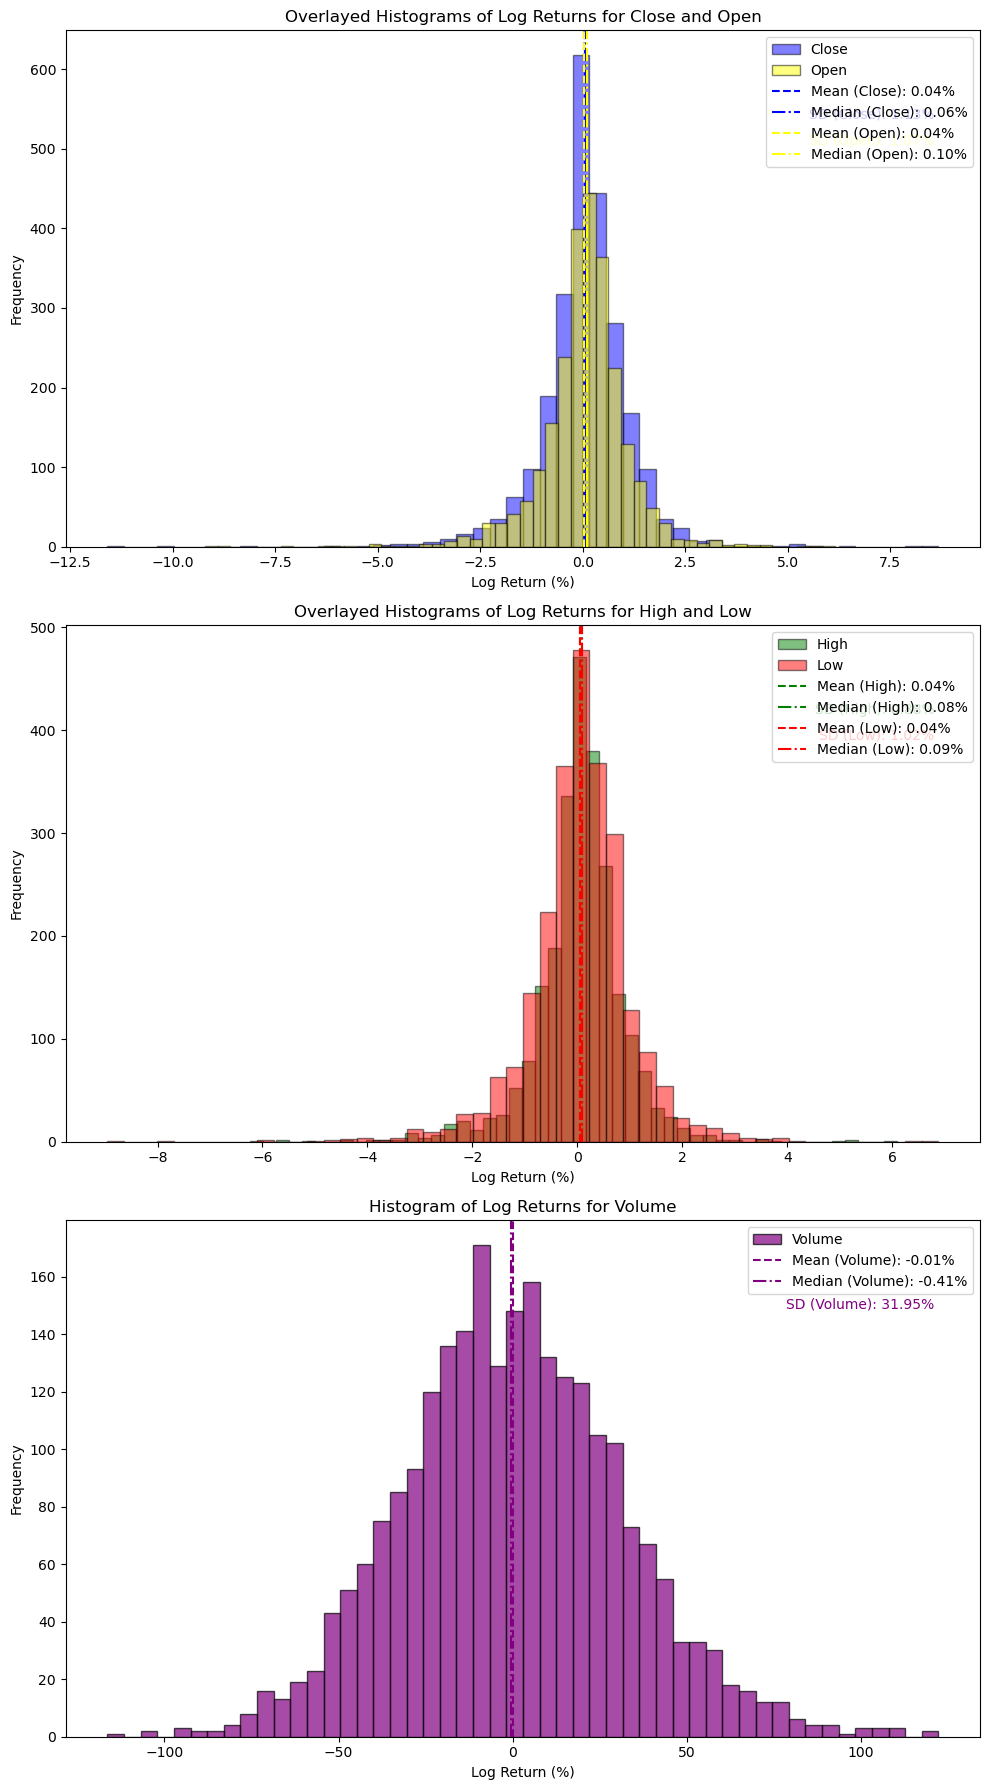

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate log returns for each column (Close/Last, Open, High, Low, Volume)
columns_to_calculate = ['Close/Last', 'Open', 'High', 'Low', 'Volume']
for column in columns_to_calculate:
    data[f'{column}_log_return'] = np.log(data[column] / data[column].shift(1)) * 100  # Convert to percentage

# Define columns for log returns
log_return_columns = ['Close/Last_log_return', 'Open_log_return', 'High_log_return', 'Low_log_return', 'Volume_log_return']

# Set up the figure for the overlapping histograms
fig, axes = plt.subplots(3, 1, figsize=(10, 18), tight_layout=True)

# Drop NaN values that result from log_return()
clean_data_close = data['Close/Last_log_return'].dropna()
clean_data_open = data['Open_log_return'].dropna()
clean_data_high = data['High_log_return'].dropna()
clean_data_low = data['Low_log_return'].dropna()
clean_data_volume = data['Volume_log_return'].dropna()

# Calculate standard deviation, mean, and median for Log Returns
std_dev_close = clean_data_close.std()
mean_close = clean_data_close.mean()
median_close = clean_data_close.median()

std_dev_open = clean_data_open.std()
mean_open = clean_data_open.mean()
median_open = clean_data_open.median()

std_dev_high = clean_data_high.std()
mean_high = clean_data_high.mean()
median_high = clean_data_high.median()

std_dev_low = clean_data_low.std()
mean_low = clean_data_low.mean()
median_low = clean_data_low.median()

std_dev_volume = clean_data_volume.std()
mean_volume = clean_data_volume.mean()
median_volume = clean_data_volume.median()

# Plot histograms for Close and Open (overlaid)
axes[0].hist(clean_data_close, bins=50, color='blue', alpha=0.5, label='Close', edgecolor='black')
axes[0].hist(clean_data_open, bins=50, color='yellow', alpha=0.5, label='Open', edgecolor='black')

# Add mean, median lines, and standard deviation text for Close and Open
axes[0].axvline(mean_close, color='blue', linestyle='--', label=f'Mean (Close): {mean_close:.2f}%')
axes[0].axvline(median_close, color='blue', linestyle='-.', label=f'Median (Close): {median_close:.2f}%')
axes[0].text(0.95, 0.85, f'SD (Close): {std_dev_close:.2f}%', horizontalalignment='right', verticalalignment='top', transform=axes[0].transAxes, color='blue')

axes[0].axvline(mean_open, color='yellow', linestyle='--', label=f'Mean (Open): {mean_open:.2f}%')
axes[0].axvline(median_open, color='yellow', linestyle='-.', label=f'Median (Open): {median_open:.2f}%')
axes[0].text(0.95, 0.80, f'SD (Open): {std_dev_open:.2f}%', horizontalalignment='right', verticalalignment='top', transform=axes[0].transAxes, color='yellow')

# Title, labels, and legend for Close and Open plot
axes[0].set_title('Overlayed Histograms of Log Returns for Close and Open')
axes[0].set_xlabel('Log Return (%)')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Plot histograms for High and Low (overlaid)
axes[1].hist(clean_data_high, bins=50, color='green', alpha=0.5, label='High', edgecolor='black')
axes[1].hist(clean_data_low, bins=50, color='red', alpha=0.5, label='Low', edgecolor='black')

# Add mean, median lines, and standard deviation text for High and Low
axes[1].axvline(mean_high, color='green', linestyle='--', label=f'Mean (High): {mean_high:.2f}%')
axes[1].axvline(median_high, color='green', linestyle='-.', label=f'Median (High): {median_high:.2f}%')
axes[1].text(0.95, 0.85, f'SD (High): {std_dev_high:.2f}%', horizontalalignment='right', verticalalignment='top', transform=axes[1].transAxes, color='green')

axes[1].axvline(mean_low, color='red', linestyle='--', label=f'Mean (Low): {mean_low:.2f}%')
axes[1].axvline(median_low, color='red', linestyle='-.', label=f'Median (Low): {median_low:.2f}%')
axes[1].text(0.95, 0.80, f'SD (Low): {std_dev_low:.2f}%', horizontalalignment='right', verticalalignment='top', transform=axes[1].transAxes, color='red')

# Title, labels, and legend for High and Low plot
axes[1].set_title('Overlayed Histograms of Log Returns for High and Low')
axes[1].set_xlabel('Log Return (%)')
axes[1].set_ylabel('Frequency')
axes[1].legend()

# Plot histogram for Volume
axes[2].hist(clean_data_volume, bins=50, color='purple', alpha=0.7, label='Volume', edgecolor='black')

# Add mean, median lines, and standard deviation text for Volume
axes[2].axvline(mean_volume, color='purple', linestyle='--', label=f'Mean (Volume): {mean_volume:.2f}%')
axes[2].axvline(median_volume, color='purple', linestyle='-.', label=f'Median (Volume): {median_volume:.2f}%')
axes[2].text(0.95, 0.85, f'SD (Volume): {std_dev_volume:.2f}%', horizontalalignment='right', verticalalignment='top', transform=axes[2].transAxes, color='purple')

# Title, labels, and legend for Volume plot
axes[2].set_title('Histogram of Log Returns for Volume')
axes[2].set_xlabel('Log Return (%)')
axes[2].set_ylabel('Frequency')
axes[2].legend()

# Show the plot
plt.show()


## <a id="section2"></a> Moving Averages: Logistic Regression (No GEE)

In [7]:
# Suppress specific FutureWarning from statsmodels globally
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, message=".*grid=True will become default in a future version.*")

# Use the prepared `data` DataFrame as `clean_data`
clean_data = data.copy()

# Number of folds for cross-validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Prepare a list to collect results
results_list = []

# Loop over each moving average from 2 to 50 days
for i in range(2, 51):
    ma_column = f'open_above_MA_{i}'
    if ma_column in clean_data.columns:
        X = clean_data[[ma_column]]
        y = clean_data['day_change_binary']
        
        # Add a constant term to the predictor
        X = sm.add_constant(X)
        
        fold_results = []
        
        # Perform k-fold cross-validation
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            # Fit the logistic regression model using robust standard errors
            model = sm.Logit(y_train, X_train)
            result = model.fit(disp=0, cov_type='HC3')  # Use 'HC3' for robust standard errors
            
            # Predict on the test set
            y_pred = result.predict(X_test)
            
            # Calculate residuals for the test set
            residuals = y_test - y_pred
            
            # Calculate metrics for the test set
            coef = result.params[ma_column]
            p_value = result.pvalues[ma_column]
            odds_ratio = np.exp(coef)
            prob = odds_ratio / (1 + odds_ratio)
            
            fold_results.append({
                'Coefficient': coef,
                'P-Value': p_value,
                'Odds Ratio': odds_ratio,
                'Probability': prob,
                'Residuals': residuals
            })
        
        # Average the results over all folds
        avg_result = {
            'Moving Average': i,
            'Coefficient': np.mean([r['Coefficient'] for r in fold_results]),
            'P-Value': np.mean([r['P-Value'] for r in fold_results]),
            'Odds Ratio': np.mean([r['Odds Ratio'] for r in fold_results]),
            'Probability': np.mean([r['Probability'] for r in fold_results]),
            'Residuals': np.concatenate([r['Residuals'] for r in fold_results])
        }
        
        # Only collect significant results with |beta| > 0.6 and p-value < 0.05
        if avg_result['P-Value'] < 0.65:
            results_list.append(avg_result)

# Convert results list to a DataFrame
results_summary = pd.DataFrame(results_list)

# Calculate confidence intervals for probabilities
results_summary['Probability Lower Bound'] = results_summary['Probability'] - 1.96 * results_summary['Probability'].std()
results_summary['Probability Upper Bound'] = results_summary['Probability'] + 1.96 * results_summary['Probability'].std()

# Sort results by coefficient for better readability
results_summary_sorted = results_summary.sort_values(by='Coefficient', ascending=False)



# Create a colormap based on p-values
norm = plt.Normalize(vmin=results_summary_sorted['P-Value'].min(), vmax=results_summary_sorted['P-Value'].max())
colors = plt.cm.viridis(norm(results_summary_sorted['P-Value']))

# Plot histogram with colors based on p-values
plt.figure(figsize=(12, 8))
bars = plt.bar(
    results_summary_sorted['Moving Average'],
    results_summary_sorted['Probability'],
    yerr=[results_summary_sorted['Probability'] - results_summary_sorted['Probability Lower Bound'],
          results_summary_sorted['Probability Upper Bound'] - results_summary_sorted['Probability']],
    capsize=5,
    color=colors
)

# Use a descriptive name for ScalarMappable
color_mapper = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
color_mapper.set_array([])  # Needed to make the colorbar work
cbar = plt.colorbar(color_mapper)
cbar.set_label('P-Value')

# Add axis labels and title
plt.xlabel('Moving Average')
plt.ylabel('Probability')
plt.title('Probability by Moving Average with P-Value Coloring')

# Show the plot
plt.show()


print('''
The logistic regression analysis confirms that shorter-term moving averages are significant predictors of the next day's price movement. Next steps would be
to determine if there is any information in the later moving averages... say 14 that is not included or already encapsulated in the 5 day.
''')

print('''
You're correct that multicollinearity is not a concern when using a single moving average as the predictor. Your approach to isolate and select the most 
predictive moving average is sound.
''')



NameError: name 'KFold' is not defined

In [ ]:
# Plot ACF and PACF for the 'day_change_binary' variable excluding lag 0
plt.figure(figsize=(12, 6))

# ACF plot excluding lag 0
plt.subplot(121)
plot_acf(clean_data['day_change_binary'], lags=19, zero=False, ax=plt.gca())
plt.title('ACF of Day Change Binary (Excluding Lag 0)')

# PACF plot excluding lag 0
plt.subplot(122)
plot_pacf(clean_data['day_change_binary'], lags=19, zero=False, ax=plt.gca())
plt.title('PACF of Day Change Binary (Excluding Lag 0)')

plt.show()



# Extract residuals for MA_2
ma_2_residuals = None
for result in results_list:
    if result['Moving Average'] == 3:
        ma_2_residuals = result['Residuals']
        break

if ma_2_residuals is not None:
    # Plot ACF and PACF for MA_3 Residuals
    plt.figure(figsize=(12, 6))

    # ACF plot for residuals of MA_2
    plt.subplot(121)
    plot_acf(ma_2_residuals, lags=19, zero=False, ax=plt.gca())
    plt.title('ACF of Residuals for MA_2')

    # PACF plot for residuals of MA_2
    plt.subplot(122)
    plot_pacf(ma_2_residuals, lags=19, zero=False, ax=plt.gca())
    plt.title('PACF of Residuals for MA_2')

    plt.show()
else:
    print("Residuals for MA_2 not found.")

    
    
# For the independent feature (ma_3) ACF and PACF plots, the code remains the same
ma_3 = data['open_above_MA_2']
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(ma_3, ax=axes[0], lags=[i for i in range(1, 21)])
axes[0].set_title('Autocorrelation Function (ACF) - MA_2 (Excluding First Lag)')
plot_pacf(ma_3, ax=axes[1], lags=[i for i in range(1, 21)])
axes[1].set_title('Partial Autocorrelation Function (PACF) - MA_2 (Excluding First Lag)')
plt.show()

print('''
The ACF measures the correlation between the residuals at different lags. 
The PACF measures the correlation between residuals at different lags, after accounting for the correlations at shorter lags.

You're right. When dealing with moving averages, especially short-term ones like MA_3, the autocorrelation at low-level lags can 
be inherently high because the moving average is computed using overlapping data points. As a result, the values of the moving 
average at consecutive lags are highly correlated.

Absolutely! If the autocorrelations quickly fall below the significance bands at higher lags, it generally suggests that any 
remaining correlations are minimal and the residuals are more "random."

You are on the right track! When testing for autocorrelation in residuals using the ACF or PACF plots at a 95% confidence level, 
it's reasonable to expect that about 5% of the lags might show significance purely by chance. If you're testing for 20 lags, seeing
one or two significant autocorrelations isn't typically a cause for alarm, as it could be attributed to random variability.

''')


In [ ]:
# Suppress specific FutureWarning from statsmodels globally
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, message=".*grid=True will become default in a future version.*")

# Ensure the DataFrame `clean_data` is correctly defined and populated
# Example setup (replace with your actual data loading steps)
data = pd.DataFrame({
    'open_above_MA_2': np.random.rand(100),  # Replace with actual data
    'day_change_binary': np.random.randint(0, 2, 100)  # Replace with actual data
})
clean_data = data.copy()

ma_column = 'open_above_MA_2'  # Example predictor

# Add a log transformation of the predictor
clean_data = clean_data.assign(
    **{f'log_{ma_column}': np.log(clean_data[ma_column] + 1e-10)}
)

# Create interaction term
clean_data[f'interaction_{ma_column}'] = clean_data[ma_column] * clean_data[f'log_{ma_column}']

# Fit the logistic regression model with the interaction term and a constant term
X = sm.add_constant(clean_data[[ma_column, f'interaction_{ma_column}']])
y = clean_data['day_change_binary']
model = sm.Logit(y, X).fit(disp=0)

# Print the summary to check the significance of the interaction term
print(model.summary())
